In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import os

from src.beam import beam_arguments, Experiment
from src.beam import UniversalDataset, UniversalBatchSampler
from src.beam import Algorithm, PackedFolds
from src.beam import DataTensor, BeamOptimizer, beam_logger

from torchvision import transforms
import torchvision
from ray import tune

import matplotlib.pyplot as plt

# Deep Learning Projects with Beam: a Step-by-Step Guide

In this tutorial we'll cover the best practices in building a new beam project. We'll go over all the essential steps when building a project from scratch and using both Jupyter and Pycharm as IDE and developement tools.

Usually, you'll get the most out of beam if you **build your project with beam** and avoid porting your existing project to beam. Therefore, we hope that after completing this guide, your first choice will always be to start a beam project from scratch. 

So, let's start.

For this tutorial we will use the CIFAR10 classification task.

Our steps will be:

1. Building a Dataset.
2. Building a neural-net.
3. Writing an iteration loop.
4. Building an algorithm based on the iteration loop.
5. Optional: building an argument parser.
6. Training your algorithm with default parameters.
7. Optimizing your hyperparameters with the Study class.


## Building a dataset

As usual we'll start with exploring the data. This time we can use torchvision to download the data.

In [2]:
path_to_data = '/localdata/elads/data/datasets/cifar10'
dataset = torchvision.datasets.CIFAR10(root=path_to_data, train=True, transform=torchvision.transforms.PILToTensor(), download=True)

Files already downloaded and verified


Here we used the ```torchvision.transforms.PILToTensor``` to transform the PIL image to tensor. Lets take for example the first image and print its associated label and shape

In [3]:
img, label = dataset[0]
print(label)
print(img.shape)

6
torch.Size([3, 32, 32])


Lets plot the image with matplotlib:

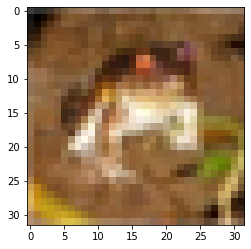

In [4]:
plt.imshow(img.permute(1, 2, 0).numpy())

Now we are ready to build our very first beam object which is the Dataset. We start by building a prototype in the notebook and later we will save it into the project .py file

First, instead of downloading and preprocessing the data each time, we will store a tensor version of both the train and the test parts of the data. If the file exists, we will directly read the data from the disk. if not, we download it and store the downloaded data as torch pickled object.

In [5]:
path = path_to_data
device = torch.device(0)

file = os.path.join(path, 'dataset_uint8.pt')
if os.path.exists(file):
    x_train, x_test, y_train, y_test = torch.load(file, map_location=device)

else:
    dataset_train = torchvision.datasets.CIFAR10(root=path, train=True,
                                                 transform=torchvision.transforms.PILToTensor(), download=True)
    dataset_test = torchvision.datasets.CIFAR10(root=path, train=False,
                                                transform=torchvision.transforms.PILToTensor(), download=True)

    x_train = torch.stack([dataset_train[i][0] for i in range(len(dataset_train))]).to(device)
    x_test = torch.stack([dataset_test[i][0] for i in range(len(dataset_test))]).to(device)

    y_train = torch.LongTensor(dataset_train.targets).to(device)
    y_test = torch.LongTensor(dataset_test.targets).to(device)

    torch.save((x_train, x_test, y_train, y_test), file)

In [6]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(x_train.device, x_test.device, y_train.device, y_test.device)
print(x_train.dtype, x_test.dtype, y_train.dtype, y_test.dtype)

torch.Size([50000, 3, 32, 32]) torch.Size([10000, 3, 32, 32]) torch.Size([50000]) torch.Size([10000])
cuda:0 cuda:0 cuda:0 cuda:0
torch.uint8 torch.uint8 torch.int64 torch.int64


The Beam Dataset object, works best with a single one-dimentional index to fetch elements from the dataset. However, in our case, we have two objects, the train and the test part. A simple solution could be to concatenate them together:

In [7]:
data = torch.cat([x_train, x_test])
labels = torch.cat([y_train, y_test])
test_indices = len(x_train) + torch.arange(len(x_test))

In this example, we also calculated the test_indices which we would like to store in order to fetch test examples.

While this solution is plausable, Beam is even more fun as it contains a PackedFolds object which is able to hold and index together multiple objects which may have different size. We can use the PackedFolds object to hold the two dataset parts, and calculate the test indices:

In [46]:
data = PackedFolds({'train': x_train, 'test': x_test})
labels = PackedFolds({'train': y_train, 'test': y_test})
test_indices = labels['test'].index

we can use the PackedFolds object to access each part of the dataset

In [9]:
data['train'].shape

torch.Size([50000, 3, 32, 32])

We can fetch and slice the data with its indices as a normal tensor. Reffer to the PackedFolds tutorial for further explenations and examples.

In [54]:
labels

{'train': tensor([6, 9, 9,  ..., 9, 1, 1]), 'test': tensor([3, 8, 8,  ..., 5, 1, 7])}

In [55]:
labels['test']

tensor([3, 8, 8,  ..., 5, 1, 7])

In [56]:
labels[40000:60000]

tensor([1, 8, 5,  ..., 5, 1, 7])

Lets build a first version of our dataset, without augmentations. We are required to write the ```__getitem__``` method that samples batches from the data for a given index vector

In [66]:
class CIFAR10Dataset(UniversalDataset):

    def __init__(self, path, device):
        super().__init__()

        file = os.path.join(path, 'dataset_uint8.pt')
        if os.path.exists(file):
            x_train, x_test, y_train, y_test = torch.load(file, map_location=device)

        else:
            dataset_train = torchvision.datasets.CIFAR10(root=path, train=True,
                                                         transform=torchvision.transforms.PILToTensor(), download=True)
            dataset_test = torchvision.datasets.CIFAR10(root=path, train=False,
                                                        transform=torchvision.transforms.PILToTensor(), download=True)

            x_train = torch.stack([dataset_train[i][0] for i in range(len(dataset_train))]).to(device)
            x_test = torch.stack([dataset_test[i][0] for i in range(len(dataset_test))]).to(device)

            y_train = torch.LongTensor(dataset_train.targets).to(device)
            y_test = torch.LongTensor(dataset_test.targets).to(device)

            torch.save((x_train, x_test, y_train, y_test), file)


        self.data = PackedFolds({'train': x_train, 'test': x_test})
        self.labels = PackedFolds({'train': y_train, 'test': y_test})

    def __getitem__(self, index):

        x = self.data[index]

        return {'x': x, 'y': self.labels[index]}

Lets make sure that we can sample a batch from this dataset:

In [67]:
dataset = CIFAR10Dataset(path_to_data, device)

In [68]:
d = dataset[10:20]
print({k: v.shape for k, v in d.items()})

{'x': torch.Size([10, 3, 32, 32]), 'y': torch.Size([10])}


while the objects ```dataset.data``` and ```dataset.labels``` contain two folds, i.e. train and test, the dataset still is not aware of the different folds and their meaning. In addition, we usually would like to split the train subset into a train-validation sets. For the dataset split purposes, beam datasets have the split method which is able to split/random split/time based split your data. It also requires a seed to generate reproducable splits. In our case, to allot 20% of the examples to the validation subset, we will call the split method as follows:

In [71]:
seed = 5782

dataset.split(validation=.2, test=dataset.labels['test'].index, seed=seed)

Now the dataset contains the ```indices_split``` dictionary which holds all the different subsets. They will be used to further generate samplers and dataloaders to iterate over the data.

In [73]:
print({k: len(v) for k, v in dataset.indices_split.items()})


{'test': 10000, 'validation': 12000, 'train': 38000}


In addition we can define different augmentations for the train/eval parts of the training. A nice property of the Beam dataset when combined with Beam algorithm is that like neural networks, it holds the ```training``` boolean property which sets the dataset in train/eval mode. The algorithm iterator toggles this property between train and eval sessions by calling ```dataset.train()``` or ```dataset.eval()``` (as with ```nn.Module``` objects). We can use this property to define different s

In [ ]:


padding = 4

augmentations = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.RandomCrop(32, padding=padding, padding_mode='edge'),])

self.t_basic = transforms.Compose([transforms.Lambda(lambda x: (x / 255)),
                                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

self.t_train = transforms.Compose([augmentations, self.t_basic])

file = os.path.join(path, 'dataset_uint8.pt')
if os.path.exists(file):
    x_train, x_test, y_train, y_test = torch.load(file, map_location=device)

else:
    dataset_train = torchvision.datasets.CIFAR10(root=path, train=True,
                                                 transform=torchvision.transforms.PILToTensor(), download=True)
    dataset_test = torchvision.datasets.CIFAR10(root=path, train=False,
                                                transform=torchvision.transforms.PILToTensor(), download=True)

    x_train = torch.stack([dataset_train[i][0] for i in range(len(dataset_train))]).to(device)
    x_test = torch.stack([dataset_test[i][0] for i in range(len(dataset_test))]).to(device)

    y_train = torch.LongTensor(dataset_train.targets).to(device)
    y_test = torch.LongTensor(dataset_test.targets).to(device)

    torch.save((x_train, x_test, y_train, y_test), file)